# Segmentación de imágenes con métodos de clustering

En esta práctica se comprenderan los métodos de clusterización para la __segmentación__ de imágenes sin etiquetar haciendo uso de técnicas de Aprendizaje Máquina No Supervisado. Como datos se utilizaran imágenes de CT de cabeza con y sin hemorragias intera-craneales.

1. Abrir imágenes DICOM y separar datos de entrenamiento y validación
2. Visualizar imagenes y preprocesamiento (Unidades de Hu y Winowing)
3. Entrenar y validar método de segmentación KMeans utilizando SKLEARN

## 1. Abrir imágenes DICOM y separar datos de entrenamiento y validación

In [1]:
import os
import pydicom
from matplotlib import pyplot as plt
import cv2
import numpy as np

def readDICOMImage(img_filename,img_path):
    
    dicom_img = pydicom.dcmread(img_path + img_filename)
    
    return dicom_img

In [2]:
#ICH images path
ich_path = "Data/ICH/"

#ICH images filenames
ich_files = next(os.walk(ich_path))[2]

#ICH Images
ich_dicom_images = []

#Read all ICH Images
for filename in ich_files:
    ich_dicom_images.append(readDICOMImage(filename,ich_path))
print("Number of ICH images: " + str(len(ich_dicom_images)))

Number of ICH images: 1000


In [3]:
import math

#Extract train and validation data set according to train percentage
def extractTrainAndValData(images):
    
    train_p = 0.9
    
    shuffled_indices = np.arange(len(images))
    np.random.shuffle(shuffled_indices)
    train_idx = shuffled_indices[:math.ceil(len(images)*train_p)] 
    
    train_images = images[train_idx]
    val_images = np.delete(images,train_idx,axis=0)
    
    return train_images,val_images

ich_dicom_images = np.array(ich_dicom_images)
[ich_train_images, ich_val_images] = extractTrainAndValData(ich_dicom_images)

In [4]:
print("Number of train images:" + str(len(ich_train_images)))
print("Number of validation images:" + str(len(ich_val_images)))

Number of train images:900
Number of validation images:100


## 2. Visualizar imagenes y preprocesamiento (Unidades de Hu y Winowing)

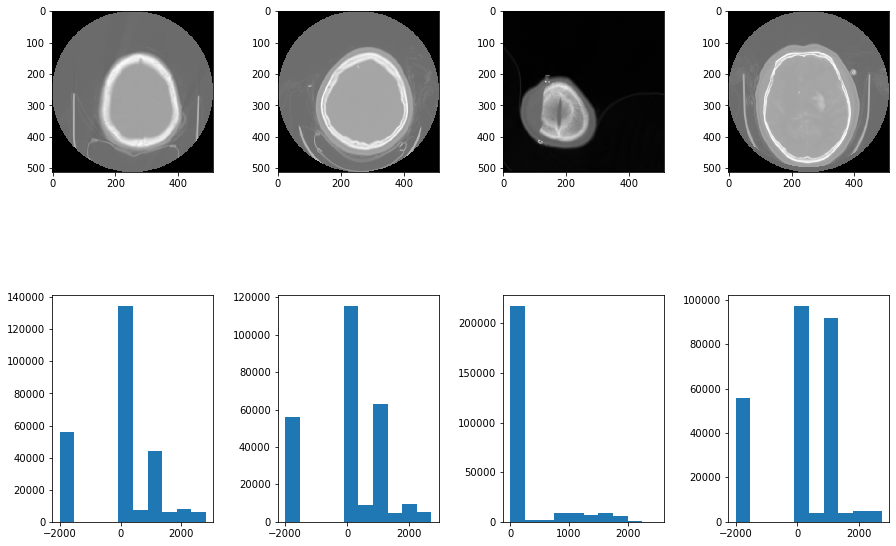

In [5]:
#Displaying random ICH images
import random 

fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

random_images = []

for i in range(4):
        n = random.randint(0,len(ich_val_images)-1)
        image = ich_val_images[n]
        random_images.append(image)
        
        ax = fig.add_subplot(2, 4, i+1)
        ax.imshow(image.pixel_array,cmap="gray")
        ax = fig.add_subplot(2, 4, i+5)
        ax.hist(image.pixel_array.ravel())

### Unidades Hounsfield

Las imáganes de CT tienen un especto de valores muy altoy son complicadas de entender, sin embargo cuando se encuentran en las unidades de __Hounsfield__, la cual es una escala cuantitativa utilizada para describir los diferentes niveles de radiodensidad de los tejidos humanos, cobran coeherencia. 

Rescalar a lestas unidades se realiza con una transformación lineal, la cual se puede realizar extrayendo información del encabezado de las imágenes __DICOM__

_RescaleSlope, RescaleIntercept_

In [6]:
def image_to_hu(dicom):
    
    image = dicom.pixel_array.astype(np.float64)
    
    # resize image
    dim = (128, 128)
    image = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
         
    # Convert to Hounsfield units (HU)
    intercept = dicom.RescaleIntercept
    slope = dicom.RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.float64)
        
    image += np.float64(intercept)
    
    image[image < -1024] = -1024 # Setting values smaller than air, to air.
    # Values smaller than -1024, are probably just outside the scanner.
    return image, dicom

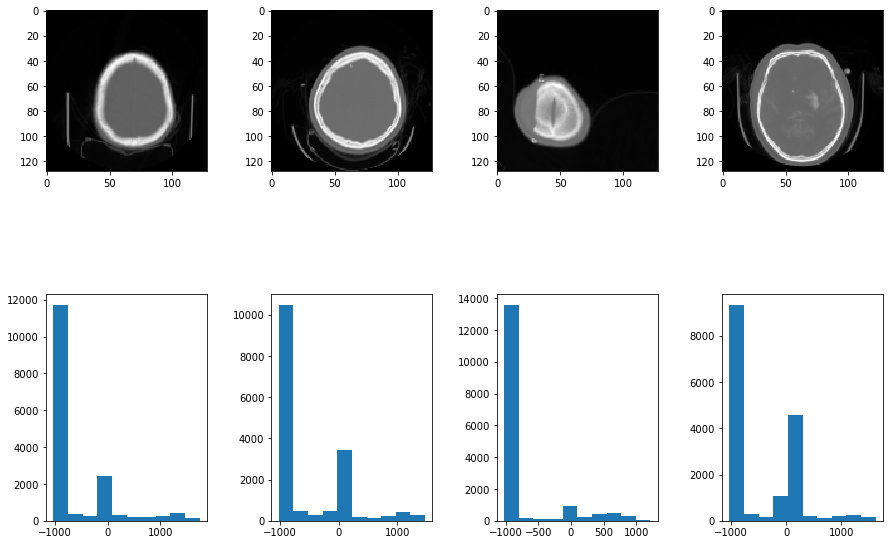

In [7]:
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

hu_random_images = []

for i in range(len(random_images)):
    
    hu_image,_ = image_to_hu(random_images[i])
    hu_random_images.append(hu_image)
    
    ax = fig.add_subplot(2, 4, i+1)
    ax.imshow(hu_image,cmap="gray")
    ax = fig.add_subplot(2, 4, i+5)
    ax.hist(hu_image.ravel())

### Windowing

Para la visualización de los tejidos humanos se deben de analizar las imágenes en un cierto rango, ya que las unidades de HU puden ir desde -1024 para el aire a valores >1000 para objetos exteraños con densidades mayores a la del hueso. Dando un rango muy amplio para su visualización. Sin embargo estos rangos se han caracterízado para su interpretación 

|Substancia|  Hu  |
|----------|------|
|Aire      |<-1024
|Grasa|-30 a -70|
|Agua|0|
|Materia Blanca|+20 a 30|
|Musculo|+20 a 40|
|Materia Gris|+20 a 40|
|Hemorragia|+65 a 95|
|Hueso|>500|







In [8]:
#Get windowed image
def window_image(img, window_c = 50, window_w = 80,out_side_val=False):
    
    image = img.copy()
    
    # see: https://www.kaggle.com/allunia/rsna-ih-detection-eda-baseline
    min_value = window_c - (window_w/2)
    max_value = window_c + (window_w/2)
    
    # Including another value for values way outside the range, to (hopefully) make segmentation processes easier. 
    out_value_min = window_c - window_w
    out_value_max = window_c + window_w
    
    if out_side_val:
        image[np.logical_and(image < min_value, image > out_value_min)] = min_value
        image[np.logical_and(image > max_value, image < out_value_max)] = max_value
        image[image < out_value_min] = out_value_min
        image[image > out_value_max] = out_value_max
    
    else:
        image[image < min_value] = min_value
        image[image > max_value] = max_value
    
    return image

#function for model to read image
def image_to_window(img):
    
    
    brain_img = window_image(img,out_side_val=True)
    hemorrage_img = window_image(img,window_c=80,window_w=30,out_side_val=True) 
    gray_matter_img = window_image(img,window_c=35,window_w=10,out_side_val=True)
    white_matter_img = window_image(img,window_c=25,window_w=10,out_side_val=True)
    bone_img = window_image(img,window_c=1000,window_w=1000,out_side_val=True)
    
    
    return brain_img, hemorrage_img, gray_matter_img, white_matter_img, bone_img

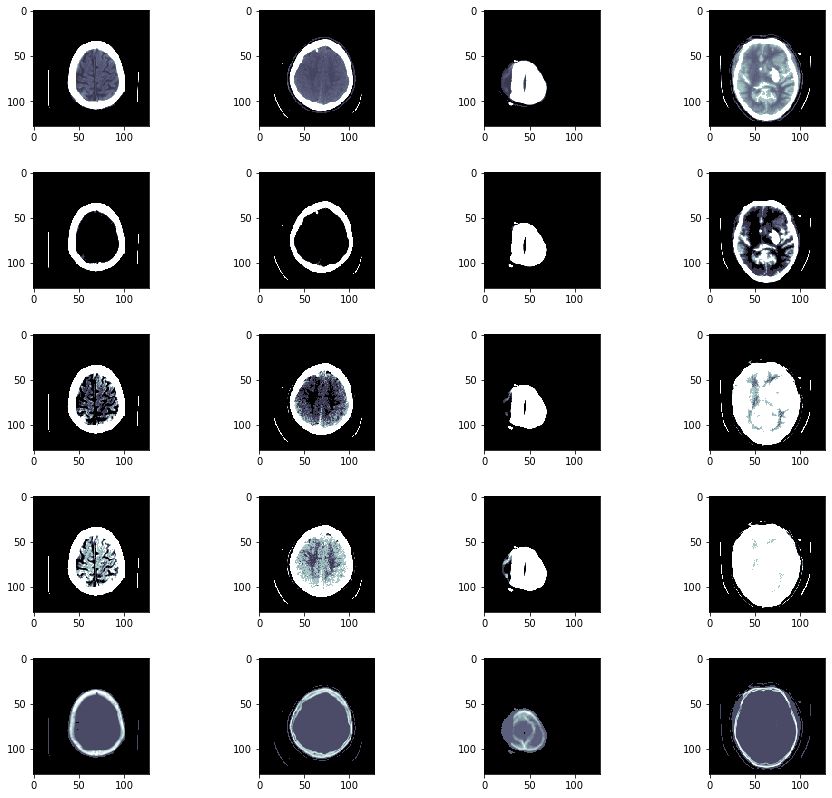

In [9]:
fig = plt.figure(figsize=(15,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

channel_val_images = []

for i in range(len(random_images)):
    
    brain_image, hemorrage_image, gray_matter_image, white_matter_image, bone_image = image_to_window(hu_random_images[i])
    
    channel_image = np.stack((brain_image, hemorrage_image, gray_matter_image, white_matter_image, bone_image),axis=2)

    channel_val_images.append(brain_image)
    
        
    ax = fig.add_subplot(7, 4, i+1)
    ax.imshow(brain_image,cmap="bone")
    ax = fig.add_subplot(7, 4, i+5)
    ax.imshow(hemorrage_image,cmap="bone")
    ax = fig.add_subplot(7, 4, i+9)
    ax.imshow(gray_matter_image,cmap="bone")
    ax = fig.add_subplot(7, 4, i+13)
    ax.imshow(white_matter_image,cmap="bone")
    ax = fig.add_subplot(7, 4, i+17)
    ax.imshow(bone_image,cmap="bone")

In [10]:
#Convert all images to HU Widnows
channel_train_images = []

for image in ich_train_images:
    
    hu_image,_ = image_to_hu(image)
    brain_image, hemorrage_image, gray_matter_image, white_matter_image, bone_image = image_to_window(hu_image)

    channel_train_images.append(brain_image)
    
    
    
    

## 3. Entrenar y validar método de segmentación KMeans utilizando SKLEARN

Se entrenara un método de clusterización de KMeans para la segmentación de imágenes de CT. Se realizara un agrupamiento de los pixeles en una amigan con respecto a su nivel en unidades de HU. 

Para segmentar nuevas imágenes se calcula el cluster más cercano para cada pixel.

In [11]:
#Obtaining 1D Pixlel Data
print("Channel Image Shape" + str(channel_train_images[0].shape))
flat_image = np.reshape(channel_train_images[0], [-1,1])
print("Flat Image Shape" + str(flat_image.shape))

Channel Image Shape(128, 128)
Flat Image Shape(16384, 1)


### Entrenar KMeans para la clusterización de pixeles con los datos de entrenamiento

In [12]:
#Flatten all train images
flat_train_images = []

for image in channel_train_images:
    
    flat_image = np.reshape(image, [-1,1])
    flat_train_images.append(flat_image)
    
flat_train_data = np.concatenate((flat_train_images))
print("Train data shape" + str(flat_train_data.shape))

np.random.shuffle(flat_train_data)

Train data shape(14745600, 1)


In [13]:
#train Kmeans
from sklearn.cluster import KMeans 

import time as time

st = time.time()
Kmeans = KMeans(n_clusters=5)
Kmeans.fit(flat_train_data)
elapsed_time = time.time() - st

print("Elapsed time: %.2fs" % elapsed_time)

Elapsed time: 116.14s


In [14]:
labels = Kmeans.labels_
centers = np.uint8(Kmeans.cluster_centers_)
print(centers)

[[227]
 [ 72]
 [ 35]
 [130]
 [ 15]]


In [15]:
def getElementsInCluster(labels):
    
    n_clusters = 5
    n_elements_cluster = []
    
    for i in range(n_clusters):
        cluster_idx = np.where(labels==i)[0]
        n_elements_cluster.append(len(cluster_idx))
    
    return n_elements_cluster

n_elements_cluster = getElementsInCluster(labels)
print(n_elements_cluster)

[10735737, 317029, 1755158, 1110677, 826999]


### Segmentar imágenes de validación.

Number of pixels in clusters[12481, 149, 1357, 1541, 856]


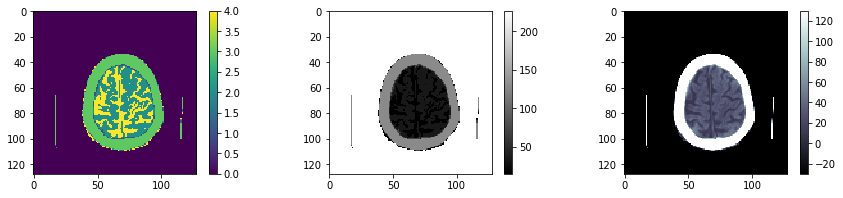

In [16]:
#Flatten image and use Kmeans to predict cluster
def predictImage(image):
    
    flat_image = np.reshape(image, [-1,1])
    labels = Kmeans.predict(flat_image)
    
    n_elements_cluster = getElementsInCluster(labels)
    print("Number of pixels in clusters" + str(n_elements_cluster))
    
    cluster_image = np.reshape(labels,(128,128))
    
    res = centers[labels.flatten()]
    center_image = res.reshape((128,128))
    
    return cluster_image, center_image

#Display cluster images,
#color of the cluster center of each pixel
#brain image for comparison
def displayClusterandWindowImage(image,center_image,channel_image):
    
    fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15, 3), ncols=3)

    im1 = ax1.imshow(image)
    fig.colorbar(im1, ax=ax1)
    im2 = ax2.imshow(center_image,cmap="gray")
    fig.colorbar(im2, ax=ax2)
    im3 = ax3.imshow(channel_image,cmap="bone")
    fig.colorbar(im3, ax=ax3)
    
    plt.show()
    
cluster_image,center_image = predictImage(channel_val_images[0],)
displayClusterandWindowImage(cluster_image,center_image,channel_val_images[0])

Number of pixels in clusters[11655, 129, 2244, 1363, 993]


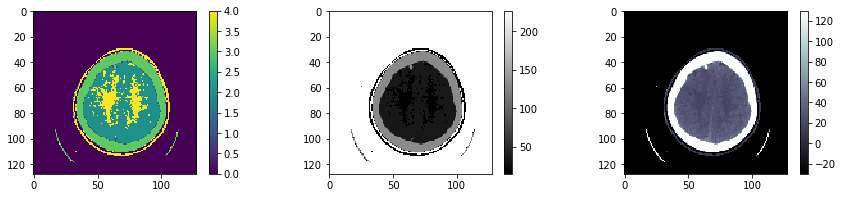

In [17]:
cluster_image,center_image = predictImage(channel_val_images[1])
displayClusterandWindowImage(cluster_image,center_image,channel_val_images[1])

Number of pixels in clusters[14399, 67, 104, 1450, 364]


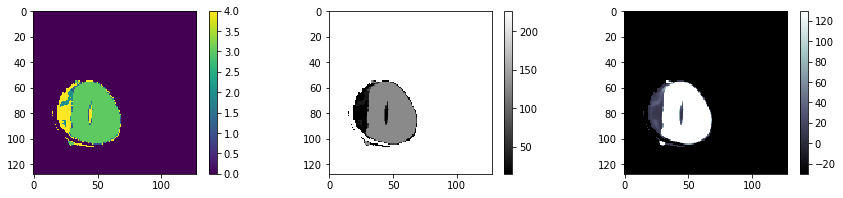

In [18]:
cluster_image,center_image = predictImage(channel_val_images[2])
displayClusterandWindowImage(cluster_image,center_image,channel_val_images[2])

Number of pixels in clusters[10291, 2570, 1581, 1457, 485]


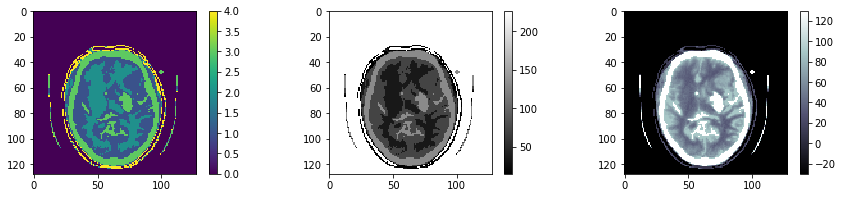

In [19]:
cluster_image,center_image = predictImage(channel_val_images[3])
displayClusterandWindowImage(cluster_image,center_image,channel_val_images[3])